#######################################################################

README
#######################################################################

1. Dataset - The file flickr8k.token.txt is not downloaded correctly through the link in the code, and should be replaced with the attached one
2. I had to use a specific version of tensorflow in order to run on GPU. This version has a bug which results in errors when trying to save and reload the trained model. Therefore, it is not possible to load the trained model and only run inference (unless somehow only the loading is incorrect, in which case it might be possible to load the attached saved model and run inference using a different version of tensorflow)

#######################################################################


In [1]:
import tensorflow as tf
from keras.models import load_model
import os
import pandas as pd
import re
import numpy as np
import collections
import random
import json
from PIL import Image
import wget
import zipfile
import pickle

In [2]:
annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
images_url = 'http://images.cocodataset.org/zips/train2017.zip'

def bar_progress(current, total, width=80):
    progress_message = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
    print(progress_message, end='\r')
    
if not os.path.exists('annotations_trainval2017.zip'):
    print("Downloading annotations")
    wget.download(annotations_url, 'annotations_trainval2017.zip', bar=bar_progress)

    with zipfile.ZipFile('annotations_trainval2017.zip', 'r') as zip_ref:
        print("\nExtracting annotations")
        zip_ref.extractall()

if not os.path.exists('train2017.zip'):
    print("Downloading images")
    wget.download(images_url, 'train2017.zip', bar=bar_progress)

    with zipfile.ZipFile('train2017.zip', 'r') as zip_ref:
        print("\nExtracting images")
        zip_ref.extractall()
        
        
images_url = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'
annotations_url = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip'


if not os.path.exists('Flicker8k_Dataset'):
    print("Downloading and extracting images")
    wget.download(images_url, 'Flickr8k_Dataset.zip', bar=bar_progress)
    
    with zipfile.ZipFile('Flickr8k_Dataset.zip', 'r') as zip_ref:
        zip_ref.extractall()
    os.remove('Flickr8k_Dataset.zip')

if not os.path.exists('Flickr8k.token.txt'):
    print("Downloading annotations")
    wget.download(annotations_url, 'Flickr8k.token.txt', bar=bar_progress)

In [3]:
# Set device to GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    
    
ANNOTATIONS_COCO = 'annotations/captions_train2017.json'
ANNOTATIONS_FLICKR = 'Flickr8k.token.txt'
TRAIN2017_DIR = 'train2017'
FLICKR_IMAGES_DIR = 'Flicker8k_Dataset'

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text) 
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

# Load both datasets
def load_data(file_path, dataset_type='coco'):
    img_caption_pairs = []

    with open(file_path, 'r', encoding='utf-8') as f:
        if dataset_type == 'coco':
            data = json.load(f)
            data = data['annotations']
            for sample in data:
                img_name = os.path.join('train2017', '%012d.jpg' % sample['image_id'])
                caption = '[start] ' + preprocess(sample['caption']) + ' [end]'
                img_caption_pairs.append({'image_id': img_name, 'caption': caption})
        elif dataset_type == 'flickr':
            for line in f:
                parts = line.strip().split('\t')
                img_name = os.path.join(FLICKR_IMAGES_DIR, parts[0])
                caption = {'image_id': img_name.split('.')[0] + '.jpg', 'caption': '[start] ' + preprocess(parts[1]) + ' [end]'}
                if os.path.exists(img_name):
                    img_caption_pairs.append(caption)

    return img_caption_pairs

def tokenize_captions(captions, max_length, vocab_size):
    
    tokenizer = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size,
        standardize=None,
        output_sequence_length=max_length)
    
    tokenizer.adapt(captions['caption'])
    vocab = tokenizer.get_vocabulary()
    
    word2idx = tf.keras.layers.StringLookup(mask_token="",vocabulary=vocab)
    idx2word = tf.keras.layers.StringLookup(mask_token="",vocabulary=vocab, invert=True)
    
    return tokenizer, word2idx, idx2word

def load_image(img_path):
    
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(360, 360)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return img

def load_data_and_prepare(img_paths, captions, tokenizer, batch_size, buffer_size):
    def load_data(img_path, caption):
        img = load_image(img_path)
        caption = tokenizer(caption)
        
        return img, caption

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, captions))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
    
    return dataset

In [4]:
coco_captions = load_data('annotations/captions_train2017.json', dataset_type='coco')
flickr_captions = load_data('Flickr8k.token.txt', dataset_type='flickr')

combined_captions = coco_captions + flickr_captions

random.shuffle(combined_captions)

train_fraction = 0.8  
split_index = int(len(combined_captions) * train_fraction)
train_data = combined_captions[:split_index]
eval_data = combined_captions[split_index:]

train_img_paths = [item['image_id'] for item in train_data]
train_captions = [item['caption'] for item in train_data]

eval_img_paths = [item['image_id'] for item in eval_data]
eval_captions = [item['caption'] for item in eval_data]

MAX_LENGTH = 15
VOCABULARY_SIZE = 15000

captions_df = pd.DataFrame(combined_captions, columns=['image_id', 'caption'])
tokenizer, word2idx, idx2word = tokenize_captions(captions_df, MAX_LENGTH, VOCABULARY_SIZE)

pickle.dump(tokenizer.get_vocabulary(), open('vocab_coco.file', 'wb'))

BATCH_SIZE = 32
BUFFER_SIZE = 1000

train_dataset = load_data_and_prepare(train_img_paths, train_captions, tokenizer, BATCH_SIZE, BUFFER_SIZE)
val_dataset = load_data_and_prepare(eval_img_paths, eval_captions, tokenizer, BATCH_SIZE, BUFFER_SIZE)

In [10]:
# Add random augmentation to prevent over fitting
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ])

def CNN():
    inception_v3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    output = inception_v3.output
    output = tf.keras.layers.Reshape((-1, output.shape[-1]))(output)
    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    
    return cnn_model
 
class Encoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, rate=0.3):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")
        self.dropout_1 = tf.keras.layers.Dropout(rate)
        self.dropout_2 = tf.keras.layers.Dropout(rate)
        self.num_heads = num_heads 
        self.embed_dim = embed_dim
        
    @tf.function
    def call(self, img, training):
        layer_norm_output = self.layer_norm_1(img)
        dense_output = self.dense(layer_norm_output)
        dropout_output = self.dropout_1(dense_output, training=training)

        attn_output = self.attention(
            query=dropout_output,
            value=dropout_output,
            key=dropout_output,
            attention_mask=None,
            training=training)

        return dropout_output + attn_output

class Embeddings(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(max_len, embed_dim, input_shape=(None, max_len))
        
    @tf.function
    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

class Decoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, units, num_heads, rate=0.3):
        super().__init__()
        self.embedding = Embeddings(tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
        self.attention_2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)

        self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dense_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.dense_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(rate)
        self.dropout_2 = tf.keras.layers.Dropout(rate)
        self.dropout_3 = tf.keras.layers.Dropout(rate)
        self.dropout_4 = tf.keras.layers.Dropout(rate)

    @tf.function
    def call(self, input_ids, encoder_output, training, mask=None):
        
        embeddings = self.embedding(input_ids)
        combined_mask = None
        padding_mask = None
        
        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training)
        
        dropout_output_1 = self.dropout_1(attn_output_1, training=training)
        norm_output_1 = self.layernorm_1(embeddings + dropout_output_1)

        attention_output_2 = self.attention_2(
            query=norm_output_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training)
        
        droptout_output_2 = self.dropout_2(attention_output_2, training=training)

        norm_output_2 = self.layernorm_2(norm_output_1 + droptout_output_2)

        dense_out = self.dense_layer_1(norm_output_2)
        dropout_out = self.dropout_3(dense_out, training=training)
        dense_out = self.dense_layer_2(dropout_out)

        norm_out = self.layernorm_3(dense_out + norm_output_2)
        dropout_out = self.dropout_4(norm_out, training=training)
        preds = self.out(dropout_out)

        return preds, attn_output_1, droptout_output_2

    def get_causal_attention_mask(self, inputs):
        
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], axis=0)
        
        return tf.tile(mask, mult)


class CaptionModel(tf.keras.Model):
    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")
        
    @tf.function
    def call(self, inputs, training=False):
        imgs, captions = inputs
        
        if self.image_aug:
            imgs = self.image_aug(imgs)

        img_embed = self.cnn_model(imgs)
        encoder_output = self.encoder(img_embed, training=training)
        input = captions[:, :-1]
        
        true_caption = captions[:, 1:]
        mask = (true_caption != 0)
        predicted_caption, _, _ = self.decoder(input, encoder_output, training=training, mask=mask)

        return predicted_caption

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        input = captions[:, :-1]
        true_caption = captions[:, 1:]
        mask = (true_caption != 0)
        
        predicted_caption, _, _ = self.decoder(input, encoder_output, training=True, mask=mask)
        
        loss = self.loss(true_caption, predicted_caption)
        loss_mask = tf.cast(mask, dtype=loss.dtype)
        loss *= loss_mask
        loss_value = tf.reduce_sum(loss) / tf.reduce_sum(loss_mask)
        
        accuracy = tf.equal(true_caption, tf.argmax(predicted_caption, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        accuracy_mask = tf.cast(mask, dtype=tf.float32)
        accuracy_value = tf.reduce_sum(accuracy) / tf.reduce_sum(accuracy_mask)
        
        return loss_value, accuracy_value


    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)

        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(img_embed, captions)

        train_vars = (self.encoder.trainable_variables + self.decoder.trainable_variables)
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch):
        
        imgs, captions = batch
        img_embed = self.cnn_model(imgs)
        loss, acc = self.compute_loss_and_acc(img_embed, captions, training=False)

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]
    

In [11]:
EMBEDDING_DIM = 512
UNITS = 512
NUM_HEADS = 2

encoder = Encoder(EMBEDDING_DIM, NUM_HEADS)
decoder = Decoder(EMBEDDING_DIM, UNITS, NUM_HEADS)

cnn_model = CNN()
caption_model = CaptionModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation)

cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction="none")

initial_learning_rate = 3e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

dummy_img = tf.zeros((BATCH_SIZE, 360, 360, 3))
dummy_captions = tf.zeros((BATCH_SIZE, MAX_LENGTH))
_ = caption_model((dummy_img, dummy_captions))

caption_model.compile(optimizer=optimizer,loss=cross_entropy)

EPOCHS = 20
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

tf.keras.backend.clear_session()
history = caption_model.fit(
    train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE),
    epochs=EPOCHS,
    validation_data=val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE),
    callbacks=[early_stopping])

Epoch 1/20
14794/14794 [==============================] - 6924s 468ms/step - loss: 2.5237 - acc: 0.4872 - val_loss: 2.3302 - val_acc: 0.5304
Epoch 2/20
14794/14794 [==============================] - 6867s 464ms/step - loss: 2.2375 - acc: 0.5365 - val_loss: 2.2493 - val_acc: 0.5399
Epoch 3/20
14794/14794 [==============================] - 6894s 466ms/step - loss: 2.1479 - acc: 0.5482 - val_loss: 2.2123 - val_acc: 0.5447
Epoch 4/20
14794/14794 [==============================] - 6896s 466ms/step - loss: 2.0989 - acc: 0.5546 - val_loss: 2.1966 - val_acc: 0.5468
Epoch 5/20
14794/14794 [==============================] - 6824s 461ms/step - loss: 2.0712 - acc: 0.5583 - val_loss: 2.1887 - val_acc: 0.5480
Epoch 6/20
14794/14794 [==============================] - 6820s 461ms/step - loss: 2.0548 - acc: 0.5605 - val_loss: 2.1847 - val_acc: 0.5486
Epoch 7/20
14794/14794 [==============================] - 6890s 466ms/step - loss: 2.0465 - acc: 0.5614 - val_loss: 2.1830 - val_acc: 0.5488
Epoch 8/20
14

In [32]:
caption_model.save('image_captioning_model')
caption_model.save_weights('image_captioning_weights')

INFO:tensorflow:Assets written to: image_captioning_model\assets


INFO:tensorflow:Assets written to: image_captioning_model\assets


In [33]:
new_captioning_model = load_model('image_captioning_model')
new_captioning_model = CaptionModel(cnn_model, encoder, decoder, image_augmentation)
new_captioning_model.load_weights('image_captioning_weights')

In [43]:
def beam_search(model, img_encoded, beam_width, top_n, max_length):
    initial_word = np.array([[word2idx('[start]')]])  
    initial_prob = 1.0  
    
    beam = [(initial_word, initial_prob)]
    
    for _ in range(max_length):
        candidates = []
        new_beam = []
        found_end_token = False
        
        for word_seq, prob in beam:
            
            preds, _, _ = model.decoder(word_seq, img_encoded, training=False)
            preds = preds[:, -1, :]  
            
            log_probs = tf.nn.log_softmax(preds)

            top_indices = list(np.argsort(log_probs[0])[::-1][:top_n])
            top_log_probs = tf.gather(log_probs[0], top_indices)  
            
            for idx, log_prob in zip(top_indices, top_log_probs):
                candidates.append((np.concatenate([word_seq, np.array([[idx]])], axis=1), prob + log_prob))
            
        if found_end_token:
            break
        
        candidates.sort(key=lambda x: x[1], reverse=True)
        new_beam.extend(candidates[:beam_width])
        new_beam.sort(key=lambda x: x[1], reverse=True)
        
        beam = new_beam[:beam_width]
    
    best_caption, _ = beam[0]
    
    caption_words = [idx2word(idx) for idx in best_caption[0]]
    caption_words = [word.numpy().decode('utf-8') for word in caption_words] 
    caption = ' '.join(caption_words[2:-1]).split('[end]')[0]
    
    return caption

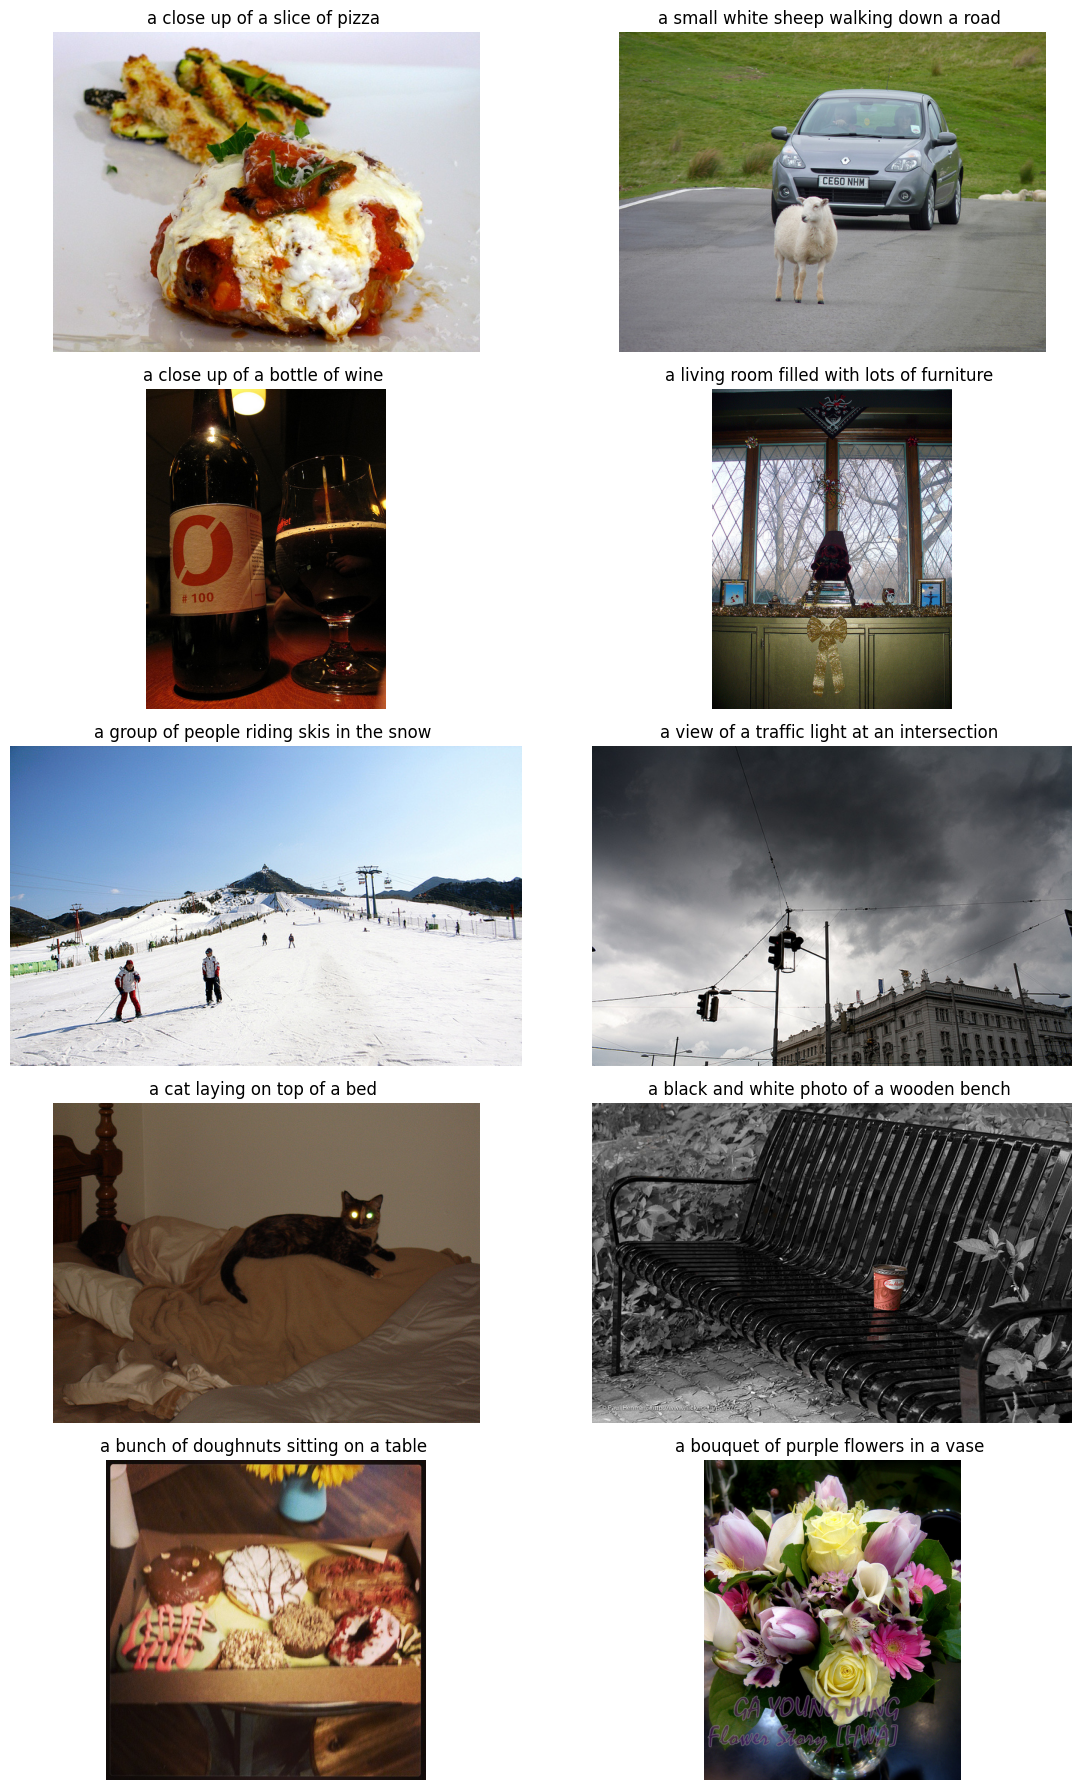

In [45]:
import matplotlib.pyplot as plt
from PIL import Image

num_images = 8
top_n = 5

plt.figure(figsize=(12, 18))
grid_rows = num_images // 2
grid_cols = 2

for i in range(num_images):
    idx = random.randrange(0, len(combined_captions))
    img_path = combined_captions.iloc[idx].image
    img = load_image(img_path)
    img = tf.expand_dims(img, axis=0)
    img_embed = new_captioning_model.cnn_model(img)
    img_encoded = new_captioning_model.encoder(img_embed, training=False)

    beam_width = MAX_LENGTH
    max_length = MAX_LENGTH

    predicted_caption = beam_search(new_captioning_model, img_encoded, beam_width, top_n, max_length)

    plt.subplot(grid_rows, grid_cols, i + 1)
    plt.imshow(Image.open(img_path))
    plt.title(predicted_caption)
    plt.axis('off')


plt.tight_layout()
plt.show()